In [9]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/MENg proj/'
npz_file = base_path + 'clean_noisy_eeg_segments.npz'
csv_file = base_path + 'segment_metadata.csv'
data = np.load(npz_file, allow_pickle=True)
noisy_data = data['noisy']
clean_data = data['clean']
metadata = pd.read_csv(csv_file)
print(f"Noisy EEG shape: {noisy_data.shape}")
print(f"Clean EEG shape: {clean_data.shape}")
print(f"Metadata shape: {metadata.shape}")
print(f"Total segments loaded: {len(clean_data)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Noisy EEG shape: (8372, 14, 1280)
Clean EEG shape: (8372, 14, 1280)
Metadata shape: (8372, 4)
Total segments loaded: 8372


In [14]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

import numpy as np
import pywt

def dwt_denoise(signal, wavelet='db4', level=4, threshold_factor=0.5):
    """
    Denoise a single EEG channel using DWT after Z-score normalization.
    """
    # Z-score normalization
    mean = np.mean(signal)
    std = np.std(signal)
    signal_norm = (signal - mean) / (std + 1e-6)  # Normalize to zero mean and unit variance

    # Wavelet decomposition
    coeffs = pywt.wavedec(signal_norm, wavelet, level=level)

    # Thresholding detail coefficients
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = threshold_factor * sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs_denoised = [coeffs[0]]
    for detail in coeffs[1:]:
        coeffs_denoised.append(pywt.threshold(detail, uthresh, mode='soft'))

    # Wavelet reconstruction
    signal_denoised = pywt.waverec(coeffs_denoised, wavelet)
    signal_denoised = signal_denoised[:len(signal)]

    return signal_denoised

def denoise_segment_dwt(noisy_segment, wavelet='db4', level=4):
    """
    Denoise a full EEG segment (shape: 14, 1280) using DWT per channel after Z-score normalization.
    """
    denoised = np.zeros_like(noisy_segment)
    for ch in range(noisy_segment.shape[0]):
        denoised[ch, :] = dwt_denoise(noisy_segment[ch, :], wavelet=wavelet, level=level)
    return denoised

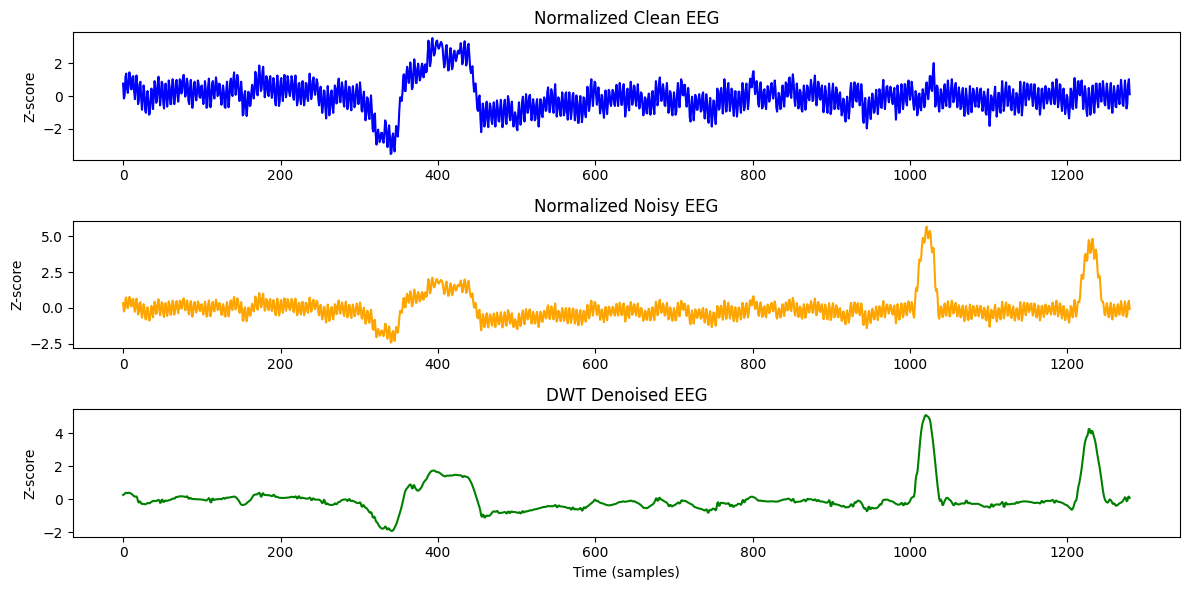

In [15]:
import matplotlib.pyplot as plt

denoised_data = np.array([denoise_segment_dwt(seg) for seg in noisy_data])

i = 0         # segment index
channel = 0   # channel index

# Apply z-score normalization on the clean and noisy segments
normalized_clean = normalize_segment_zscore(clean_data[i])[channel]
normalized_noisy = normalize_segment_zscore(noisy_data[i])[channel]
denoised = denoise_segment_dwt(noisy_data[i])[channel]

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(normalized_clean, label='Normalized Clean', color='blue')
plt.title('Normalized Clean EEG')
plt.ylabel('Z-score')

plt.subplot(3, 1, 2)
plt.plot(normalized_noisy, label='Normalized Noisy', color='orange')
plt.title('Normalized Noisy EEG')
plt.ylabel('Z-score')

plt.subplot(3, 1, 3)
plt.plot(denoised, label='DWT Denoised', color='green')
plt.title('DWT Denoised EEG')
plt.ylabel('Z-score')
plt.xlabel('Time (samples)')

plt.tight_layout()
plt.show()


Metrics

In [16]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

def compute_mse(clean, denoised):
    return mean_squared_error(clean.flatten(), denoised.flatten())
def compute_snr(clean, denoised):
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - denoised) ** 2)
    return 10 * np.log10(signal_power / noise_power + 1e-8)
def compute_correlation(clean, denoised):
    r_values = []
    for ch in range(clean.shape[0]):
        r, _ = pearsonr(clean[ch], denoised[ch])
        r_values.append(r)
    return np.mean(r_values)


In [25]:
total_mse, total_snr, total_corr = 0, 0, 0

for i in range(len(clean_data)):
    clean = normalize_segment_zscore(clean_data[i])
    noisy = normalize_segment_zscore(noisy_data[i])
    denoised = denoise_segment_dwt(noisy_data[i])

    total_mse += compute_mse(clean, denoised)
    total_snr += compute_snr(clean, denoised)
    total_corr += compute_correlation(clean, denoised)

n = len(clean_data)



Average MSE: 0.3966
Average SNR: 4.94 dB
Average Correlation: 0.7891


In [26]:
print(f"Average MSE: {total_mse / n:}")
print(f"Average SNR: {total_snr / n:} dB")
print(f"Average Correlation: {total_corr / n:}")

Average MSE: 0.39664274625104695
Average SNR: 4.9403660952778985 dB
Average Correlation: 0.7890799014893654
